# Sentiment Analysis with LSTMs

Sentiment analysis can be thought of as the exercise of taking a sentence, paragraph, document, or any piece of natural language, and determining whether that text's emotional tone is positive, negative or neutral. 

# Word Vectors

The common theme is that the inputs need to be scalar values, or matrices of scalar values. When you think of sentiment analysis (as NLP task), however, a data pipeline like this may come to mind. 
 
![caption](Images/SentimentAnalysis.png)

This kind of pipeline is problematic. There is no way for us to do common operations like dot products or backpropagation on a single string. Instead of having a string input, we will need to convert each word in the sentence to a vector. 

![caption](Images/SentimentAnalysis2.png)

You can think of the input to the sentiment analysis module as being a 16 x D dimensional matrix. 

We want these vectors to be created in such a way that they somehow represent the word and its context, meaning, and semantics. For example, we’d like the vectors for the words “love” and “adore” to reside in relatively the same area in the vector space since they both have similar definitions and are both used in similar contexts. The vector representation of a word is also known as a word embedding.

![caption](Images/SentimentAnalysis8.png)

# Word2Vec

In order to create these word embeddings, we'll use a model that's commonly reffered to as "Word2Vec". 

The output of a Word2Vec model is called an embedding matrix.

# Recurrent Neural Networks (RNNs)

Let's look at the actual network architecture we're going to be building. 
Each word in a sentence depends greatly on what came before and comes after it. 
In order to account for this dependency, we use a recurrent neural network.  

![caption](Images/SentimentAnalysis18.png)

The main difference between feedforward neural networks and recurrent ones is the temporal aspect of the latter. In RNNs, each word in an input sequence will be associated with a specific time step. In effect, the number of time steps will be equal to the max sequence length. 

![caption](Images/SentimentAnalysis16.png)

The hidden state is a function of both the current word vector and the hidden state vector at the previous time step. The sigma indicates that the sum of the two terms will be put through an activation function (normally a sigmoid or tanh).

![caption](Images/SentimentAnalysis15.png) 

The weight matrices are updated through an optimization process called backpropagation through time. 

The hidden state vector at the final time step is fed into a binary softmax classifier where it is multiplied by another weight matrix and put through a softmax function that outputs values between 0 and 1, effectively giving us the probabilities of positive and negative sentiment. 

# Long Short Term Memory Units (LSTMs) 

What if the middle sentence had no impact? However, there is a strong connection between the first and third sentences. LSTMs help in handling long term dependencies.

The computation is broken up into 4 components, an input gate, a forget gate, an output gate, and a new memory container. 

![caption](Images/SentimentAnalysis10.png)
 

# Framing Sentiment Analysis as a Deep Learning Problem

As mentioned before, the task of sentiment analysis involves taking in an input sequence of words and determining whether the sentiment is positive, negative, or neutral. We can separate this specific task (and most other NLP tasks) into 5 different components.

    1) Training a word vector generation model (such as Word2Vec) or loading pretrained word vectors
    2) Creating an ID's matrix for our training set (We'll discuss this a bit later)
    3) RNN (With LSTM units) graph creation
    4) Training 
    5) Testing

# Loading Data 

First, we want to create our word vectors. For simplicity, we're going to be using a pretrained model. 

We'd use those vectors - matrix that is trained using [GloVe](http://nlp.stanford.edu/projects/glove/), a similar word vector generation model. The matrix will contain 400,000 word vectors, each with a dimensionality of 50. 

We're going to be importing two different data structures, one will be a Python list with the 400,000 words, and one will be a 400,000 x 50 dimensional embedding matrix that holds all of the word vector values. 

In [1]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] 
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


In [2]:
# dimensions of the vocabulary list and the embedding matrix. 
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


In [3]:
#access its corresponding vector through the embedding matrix. (word: tree)
baseballIndex = wordsList.index('tree')
wordVectors[baseballIndex]

array([ 0.62231 ,  1.1986  , -0.014116,  0.20125 ,  0.69419 ,  0.12068 ,
       -0.90399 , -1.4023  ,  0.43357 , -0.48537 , -0.4645  ,  0.15756 ,
        0.54261 , -0.32467 , -0.025646,  0.45742 ,  0.16561 ,  0.18819 ,
        0.062099, -0.86418 , -1.0425  , -0.81157 ,  0.3126  , -0.20279 ,
        0.55734 , -0.28634 , -0.14874 ,  1.0098  ,  0.25041 , -0.53195 ,
        2.3793  , -0.76966 , -0.63219 ,  0.3203  ,  0.15072 ,  0.23326 ,
       -0.26254 , -0.29461 ,  0.7671  , -0.11577 , -0.68129 , -0.65413 ,
       -0.58914 ,  0.24684 ,  1.5904  ,  0.33025 ,  0.41513 , -1.7468  ,
        0.82453 , -1.0886  ], dtype=float32)

Now that we have our vectors, our first step is taking an input sentence and then constructing the its vector representation. Let's say that we have the input sentence "I thought the movie was incredible and inspiring". In order to get the word vectors, we can use Tensorflow's embedding lookup function. 

In [4]:
import tensorflow as tf
maxSeqLength = 10 #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

/home/saprem/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


The data pipeline can be illustrated below.

![caption](Images/SentimentAnalysis5.png)

The 10 x 50 output should contain the 50 dimensional word vectors for each of the 10 words in the sequence. 

In [5]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(10, 50)


The training set we're going to use is the **Imdb movie review dataset**. This set has 25,000 movie reviews, with 12,500 positive reviews and 12,500 negative reviews. Each of the reviews is stored in a txt file that we need to parse through. The positive reviews are stored in one directory and the negative reviews are stored in another. The following piece of code will determine total and average number of words in each review. 

# Data preprocessing

In [6]:
from os import listdir
import io
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in listdir('positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('negativeReviews/') if isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with io.open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with io.open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
('The total number of files is', 25000)
('The total number of words in the files is', 5844680)
('The average number of words in the files is', 233)


We can also use the Matplot library to visualize this data in a histogram format. 

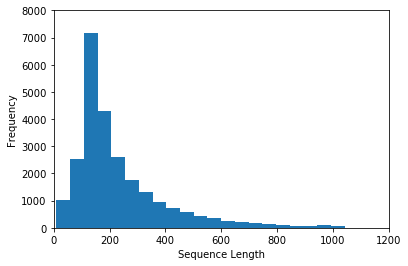

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

From the histogram as well as the average number of words per file, we can safely say that most reviews will fall under 250 words, which is the max sequence length value we will set. 

In [8]:
maxSeqLength = 250

Let's see how we can take a single file and transform it into our ids matrix. This is what one of the reviews looks like in text file format.

In [9]:
fname = positiveFiles[3] 
with open(fname) as f:
    for lines in f:
        print(lines)
        exit

This is easily the most underrated film inn the Brooks cannon. Sure, its flawed. It does not give a realistic view of homelessness (unlike, say, how Citizen Kane gave a realistic view of lounge singers, or Titanic gave a realistic view of Italians YOU IDIOTS). Many of the jokes fall flat. But still, this film is very lovable in a way many comedies are not, and to pull that off in a story about some of the most traditionally reviled members of society is truly impressive. Its not The Fisher King, but its not crap, either. My only complaint is that Brooks should have cast someone else in the lead (I love Mel as a Director and Writer, not so much as a lead).


Now, let's convert to to an ids matrix

In [10]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [11]:
firstFile = np.zeros((maxSeqLength), dtype='int32')
with open(fname) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        if indexCounter < maxSeqLength:
            try:
                firstFile[indexCounter] = wordsList.index(word)
            except ValueError:
                firstFile[indexCounter] = 399999 #Vector for unknown words
        indexCounter = indexCounter + 1
firstFile

array([    37,     14,   2407, 201534,     96,  37314,    319,   7158,
       201534,   6469,   8828,   1085,     47,   9703,     20,    260,
           36,    455,      7,   7284,   1139,      3,  26494,   2633,
          203,    197,   3941,  12739,    646,      7,   7284,   1139,
            3,  11990,   7792,     46,  12608,    646,      7,   7284,
         1139,      3,   8593,     81,  36381,    109,      3, 201534,
         8735,    807,   2983,     34,    149,     37,    319,     14,
          191,  31906,      6,      7,    179,    109,  15402,     32,
           36,      5,      4,   2933,     12,    138,      6,      7,
          523,     59,     77,      3, 201534,     96,   4246,  30006,
          235,      3,    908,     14,   4702,   4571,     47,     36,
       201534,   6429,    691,     34,     47,     36,  35404,    900,
          192,     91,   4499,     14,     12,   6469,    189,     33,
         1784,   1318,   1726,      6, 201534,    410,     41,    835,
      

Now, let's do the same for each of our 25,000 reviews. We'll load in the movie training set and integerize it to get a 25000 x 250 matrix.

In [ ]:
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
for pf in positiveFiles:
   with open(pf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 

for nf in negativeFiles:
   with open(nf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 
#Pass into embedding function and see if it evaluates. 

np.save('idsMatrix', ids)

In [12]:
ids = np.load('idsMatrix.npy')

LET'S BEGIN

In [13]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

# RNN Model

Now, we’re ready to start creating our Tensorflow graph. We’ll first need to define some hyperparameters, such as batch size, number of LSTM units, number of output classes, and number of training iterations. 

In [28]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 100000

As with most Tensorflow graphs, we’ll now need to specify two placeholders, one for the inputs into the network, and one for the labels.  

The labels placeholder represents a set of values, each either [1, 0] or [0, 1], depending on whether each training example is positive or negative. Each row in the integerized input placeholder represents the integerized representation of each training example that we include in our batch.

![caption](Images/SentimentAnalysis12.png)

In [15]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

![caption](Images/SentimentAnalysis13.png)

In [16]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

Finally, we’ll feed both the LSTM cell and the 3-D tensor full of input data

In [17]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [18]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

Next, we’ll define correct prediction and accuracy metrics to track how the network is doing. The correct prediction formulation works by looking at the index of the maximum value of the 2 output values, and then seeing whether it matches with the training labels. 

In [19]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

We’ll define a standard cross entropy loss with a softmax layer put on top of the final prediction values. For the optimizer, we’ll use Adam and the default learning rate of .001. 

In [20]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

# Hyperparameter Tuning

Choosing the right values for your hyperparameters is a crucial part of training deep neural networks effectively. 

* Learning Rate
* Optimizer
* Number of LSTM units
* Word Vector Size

# Training

In [29]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
   #Next Batch of reviews
   nextBatch, nextBatchLabels = getTrainBatch();
   sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   

   #Save the network every 10,000 training iterations
   if (i % 10000 == 0 and i != 0):
       save_path = saver.save(sess, "models_trained/pretrained_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)


saved to models_trained/pretrained_lstm.ckpt-10000
saved to models_trained/pretrained_lstm.ckpt-20000
saved to models_trained/pretrained_lstm.ckpt-30000
saved to models_trained/pretrained_lstm.ckpt-40000
saved to models_trained/pretrained_lstm.ckpt-50000
saved to models_trained/pretrained_lstm.ckpt-60000
saved to models_trained/pretrained_lstm.ckpt-70000
saved to models_trained/pretrained_lstm.ckpt-80000
saved to models_trained/pretrained_lstm.ckpt-90000


In [30]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

('Accuracy for this batch:', 79.16666865348816)
('Accuracy for this batch:', 83.33333134651184)
('Accuracy for this batch:', 66.66666865348816)
('Accuracy for this batch:', 87.5)
('Accuracy for this batch:', 87.5)
('Accuracy for this batch:', 83.33333134651184)
('Accuracy for this batch:', 91.66666865348816)
('Accuracy for this batch:', 91.66666865348816)
('Accuracy for this batch:', 83.33333134651184)
('Accuracy for this batch:', 95.83333134651184)


In [32]:
def getSentenceMatrix(sentence):
    arr = np.zeros([batchSize, maxSeqLength])
    sentenceMatrix = np.zeros([batchSize,maxSeqLength], dtype='int32')
    cleanedSentence = cleanSentences(sentence)
    split = cleanedSentence.split()
    for indexCounter,word in enumerate(split):
        try:
            sentenceMatrix[0,indexCounter] = wordsList.index(word)
        except ValueError:
            sentenceMatrix[0,indexCounter] = 399999 #Vector for unkown words
    return sentenceMatrix

In [33]:
inputText = "That movie was terrible."
inputMatrix = getSentenceMatrix(inputText)
predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]
# predictedSentiment[0] represents output score for positive sentiment
# predictedSentiment[1] represents output score for negative sentiment

if (predictedSentiment[0] > predictedSentiment[1]):
    print "Positive Sentiment"
else:
    print "Negative Sentiment"

Negative Sentiment


In [34]:
secondInputText = "That movie was the best one I have ever seen."
secondInputMatrix = getSentenceMatrix(secondInputText)
predictedSentiment = sess.run(prediction, {input_data: secondInputMatrix})[0]
if (predictedSentiment[0] > predictedSentiment[1]):
    print "Positive Sentiment"
else:
    print "Negative Sentiment"

Positive Sentiment


In [36]:
thirdInputText = "Justic League was the not as good as expected."
thirdInputMatrix = getSentenceMatrix(thirdInputText)
predictedSentiment = sess.run(prediction, {input_data: thirdInputMatrix})[0]
if (predictedSentiment[0] > predictedSentiment[1]):
    print "Positive Sentiment"
else:
    print "Negative Sentiment"

Negative Sentiment


In [37]:
fourthInputText = "I thought XYZ movie would be not so good but turn out to be excellent."
fourthInputMatrix = getSentenceMatrix(fourthInputText)
predictedSentiment = sess.run(prediction, {input_data: fourthInputMatrix})[0]
if (predictedSentiment[0] > predictedSentiment[1]):
    print "Positive Sentiment"
else:
    print "Negative Sentiment"

Positive Sentiment
